In [1]:
## Import required python packages (and pyrcel)

import pyrcel as pm
import numpy as np
import matplotlib.pyplot as plt

/Users/jrp21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Repositories/pyrcel-public/pyrcel-for-contrails/pyrcel/_parcel_aux_numba.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC


In [ ]:
from pyrcel import binned_activation

## Define functions for describing contrail formation, see B Kärcher et al., 2015 for more information

def es(T): 
    """See :func:`pyrcel.thermo.es` for full documentation"""
    return 611.2 * np.exp(17.67 * T / (T + 243.5)) 

def p_i_0(T): 
    """Calculates the saturation vapour pressure above a flat surface of ice.

    Parameters
    ----------
    T : array_like

    Returns
    -------
    x : array_like
        Saturation vapour pressure above a flat surface of ice according to Murphy and Koop, 2005
    """   
    return np.exp(9.550426 - 5723.265/T + 3.53068 * np.log(T) - 0.00728332*T) 

def p_mw(T, T_a, G, RHi): 
    """Calculates the water vapour pressure along the contrail mixing line

    Parameters
    ----------
    T : array_like
        Plume temperature, in Kelvin
    T_a : float
        Ambient temperature, in Kelvin
    RHi : float
        Ambient relative humidity with respect to ice

    Returns
    -------
    x : array_like
        Water vapour pressure along the contrail mixing line
    """       
    p_wa = p_i_0(T_a) * RHi
                    
    return p_wa + G * (T - T_a) 

def Smw(T, T_a, G, RHi): 
    """Calculates the water saturation ratio along the contrail mixing line

    Parameters
    ----------
    T : array_like
        Plume temperature, in Kelvin
    T_a : float
        Ambient temperature, in Kelvin
    RHi : float
        Ambient relative humidity with respect to ice
    
    Returns
    -------
    x : array_like
        Water saturation ratio along the contrail mixing line
    """               
    return p_mw(T, T_a, G, RHi)/es(T-273.15)

def n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end, RHi, G):

    """Calculates either the total emission index of ice crystals (at 230K) or returns the parcel and aerosol traces

    Parameters
    ----------
    T_a : array_like
        Plume temperature, in Kelvin
    T_e : float
        Ambient temperature, in Kelvin
    P0 : float
        Total atmospheric pressure, in Pa
    n_ambient : float
        Number concentration of ambient particles, in cm^-3
    GMD_ambient, GMD_vPM, GMD_nvPM : float
        Geometric mean diamter of the ambient particle size distribution, nvPM and vPM.
    kappa_ambient, kappa_vPM, kappa_nvPM : float
       Hygroscopicity of the ambient, nvPM and vPM particles
    bins_ambient, bins_vPM, bins_nvPM : float
        Number of bins used to model the ambient, nvPM and vPM particle size distributions
    EI_vPM, EI_nvPM : float
        Emission index of vPM and nvPM, in particles per kg of fuel burned
    T_start : float
        Initial simulation temperature, in Kelvin
    dt : float
        Model timestep, in s
    t_end : float
        Model end time, in s
    RHi : array_like
        Ambient relative humidity with respect to ice
    G : float
        Contrail mixing line gradient, in Pa/K
        
    Returns
    -------
    x : float or array_like
        Either the total emission index of ice crystals (at 230K) or the parcel and aerosol traces
    """               

    S0 = Smw(T_start, T_a, G, RHi) - 1 # water supersaturation at initial model temperature / K 

    ## Initialise particle modes (note that mu = GRD of mode in micrometers)

    N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
    N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

    ambient =  pm.AerosolSpecies('ambient',
                                pm.Lognorm(mu=GMD_ambient * 0.5e6, sigma=GSD_ambient, N=n_ambient),
                                kappa=kappa_ambient, bins=int(bins_ambient))
                                
    vPM =  pm.AerosolSpecies('vPM',
                                pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                                kappa=kappa_vPM, bins=int(bins_vPM))

    nvPM =  pm.AerosolSpecies('nvPM',
                                pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                                kappa=kappa_nvPM, bins=int(bins_nvPM))                              

    initial_aerosols = [vPM, nvPM, ambient]

    ## Model initialisation and calculation

    model = pm.ParcelModel(initial_aerosols, np.array([T_a, P0, RHi, G, T_e]), T_start, S0, P0, console=False, accom=1.0, truncate_aerosols=True) # array for Ta gives room for any parameters to be passed into the model i.e., 

    parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

    ## Maximum supersaturation

    S_max = np.max(parcel_trace['S']) * 100 # maximum plume supersaturation achieved / %
    idxmax = np.argmax(parcel_trace['S']) # index of above

    ## Estimate properties at a plume temperature of 230K, this provides equilibrium values but does not run into difficulty with low temperature instability (due to parameterization of homogeneous ice nucleation)

    T_of_interest = 230
    T_x = np.argmin(np.abs(parcel_trace['T'] - T_of_interest))

    nvPM_trace = aerosol_traces['nvPM']
    vPM_trace = aerosol_traces['vPM']
    ambient_trace = aerosol_traces['ambient']

    max_n_vPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], vPM_trace.iloc[T_x],  vPM, T_a, P0, T_e) # activated fractions at maximum supersaturation
    max_n_nvPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], nvPM_trace.iloc[T_x],  nvPM, T_a, P0, T_e) # activated fractions at maximum supersaturation
    max_n_ambient = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], ambient_trace.iloc[T_x],  ambient, T_a, P0, T_e) # activated fractions at maximum supersaturation

    max_n_total = (max_n_nvPM + max_n_vPM + max_n_ambient)

    # return max_n_total # return the total ice crystal emission index, in particles per kg of fuel
    return parcel_trace, aerosol_traces # return the parcel and aerosol traces

In [ ]:
## Example model simulation

## Define contrail properties

T_a = 215.00 # ambient temperature, in Kelvin
T_e = 600.0 # exhaust temperature, in Kelvin
P0 = 22919.5 # (cruise) pressure, in Pa 

RHi = 1.1 # ice saturation ratio 
G = 1.64 # contrail mixing line gradient, in Pa/K

## Define particle properties

n_ambient = 600 # number concentration of ambient particles, in cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, in particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, in particles per kg of fuel burned

## Geometric mean diameter and standard deviation of the three particle modes

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # do not change kappa_ambient
GMD_nvPM, GSD_nvPM, kappa_nvPM = 35e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-09, 1.3, 0.5
bins_nvPM, bins_ambient, bins_vPM = 50, 50, 50

## Define model simulation conditions

T_start = 270.0 # initial model (not the ambient temperature) temperature / K
dt = 1e-3 # model timestep, in s
t_end = 1 # model end time, in s

## Call the model (returns maximum supersaturation as % and effective emission index of ice as particles per kg-fuel)

parcel_trace, aerosol_traces = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end, RHi, G)

# AEI_ice = n_droplets(T_a, T_e, P0, 
#                n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
#                EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
#                EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
#                T_start, dt, t_end, RHi, G)

# print(AEI_ice/EI_nvPM)

/Users/jrp21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Repositories/pyrcel-public/pyrcel-for-contrails/pyrcel/integrator.py:30: UserWarning: Could not import odespy package; invoking the 'lsoda' or 'lsode' options will fail!
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2.0270345689522604


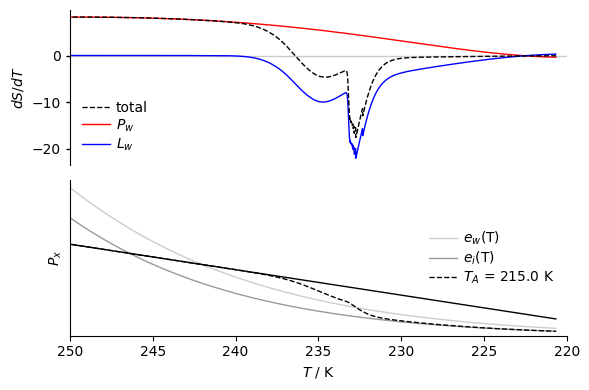

In [4]:
"""SUPERSATURATION FORCING GRAPHS, LW and PW"""

## Define parameters used to describe contrail dilution using one of two methods:

## (1) according to B Kärcher et al., 2015
tau_m = 10e-3 # timescale over which contrail mixing is unaffected by entrainment, in seconds
beta = 0.9 # plume dilution parameter

## (2) according to U Schumann et al., 1998 (used in Schuman et al., 2012)
## tau_m = 10 ** (np.log10((70/7000))/0.8)
## beta = 0.8

T = np.array(parcel_trace["T"]) # plume temperature, in Kelvin
t = tau_m * ((T_e - T_a) / (T - T_a)) ** (1/beta) # time into contrail evolution, in seconds

S_mw = Smw(T, T_a, G, RHi)
P_w = np.gradient(S_mw, t)
S_total = parcel_trace["S"]
dS_dt_total = np.gradient(S_total, t)
L_w = dS_dt_total - P_w 

## Plotting
fig = plt.figure(figsize = (6, 4))

## Plot terms describing generation and depletion of supersaturation
ax = fig.add_subplot(2, 1, 1)

ax.axhline(y = 0, color = "black", alpha = 0.2, linewidth = 1)
ax.plot(T, dS_dt_total, color = "black", linestyle = "--", linewidth = 1, zorder = 10, label = "total")
ax.plot(T, P_w, color = "red", linewidth = 1, label = "$\it{P}$$_{w}$")
ax.plot(T, L_w, color = "blue", linewidth = 1, label = "$\it{L}$$_{w}$")

## Set the axis parameters
ax.legend(handletextpad = 0.4, labelspacing = 0.2, frameon = False, loc = "lower left")
ax.spines[["right", "top", "bottom"]].set_visible(False)

ax.set_ylabel("$d\it{S}$/$d\it{T}$")
ax.set_xlim([250, 220])
ax.set_xticks([])
ax.tick_params(which='major', width=1, length = 3)

## Plot terms describing the characteristics of contrail mixing
ax1 = fig.add_subplot(2, 1, 2)

ax1.plot(T, es(T - 273.15), color = "black", alpha = 0.2, linewidth = 1, label = "$\it{e}$$_{w}$(T)")
ax1.plot(T, p_i_0(T) * 1., color = "grey", alpha = 0.8, linewidth = 1, label = "$\it{e}$$_{i}$(T)")
ax1.plot(T, (S_total + 1) * es(T - 273.15), color = "black", linewidth = 1, linestyle = "--", label = "$\it{T}$$_{A}$ = "f"{T_a:.1f} K")
ax1.plot(T, p_mw(T, T_a, G, RHi), linewidth = 1, color = "black")

ax1.set_ylabel("$\it{P}$$_{x}$")
ax1.set_xlabel("$\it{T}$ / K")

ax1.set_yticks([])
ax1.set_ylim([0, 100])
ax1.set_xlim([250, 220])

ax1.legend(handletextpad = 0.4, labelspacing = 0.2, frameon = False, loc = "center right")
ax1.spines[["right", "top"]].set_visible(False)

plt.tight_layout()
plt.show() 